In [136]:
import statsmodels.formula.api as smf
import wooldridge as woo
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import statsmodels.api as sm
import scipy.stats as stats
import patsy as pt


In [137]:
data = woo.data("gpa3")

### AIC

$$ AIC = ln(\frac{SSE}{N})+\frac{2K}{N}$$

In [138]:
# Fit the model
model = smf.ols('cumgpa ~ sat +hsperc +tothrs +female +black + white', data)
results = model.fit()

In [139]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 cumgpa   R-squared:                       0.241
Model:                            OLS   Adj. R-squared:                  0.234
Method:                 Least Squares   F-statistic:                     38.31
Date:                Fri, 04 Nov 2022   Prob (F-statistic):           1.73e-40
Time:                        10:51:52   Log-Likelihood:                -929.74
No. Observations:                 732   AIC:                             1873.
Df Residuals:                     725   BIC:                             1906.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8791      0.298      2.952      0.003       0.294       1.464
sat            0.0009      0.000      3.743      0.000       0.000       0.001
hsperc        -0.0056      0.002     -3.463      0.001      -0.009      -0.002
tothrs         0.0121      0.001     12.941      0.000       0.010       0.014
female         0.1667      0.077      2.164      0.031       0.015       0.318
black         -0.0261      0.192     -0.136      0.892      -0.403       0.351
white          0.0143      0.184      0.078      0.938      -0.347       0.375
==============================================================================
Omnibus:                       15.717   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.426
Skew:                           0.088   Prob(JB):                     6.72e-07
Kurtosis:                       3.949   Cond. No.                     1.01e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.01e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [19]:
# manual AIC using the formula
def AIC(model, y):
    
    # get SSE
    SSE = ((model.resid)**2).sum()
    
    # Get K and N
    k = len(results.params)
    N = len(results.fittedvalues)
    
    # Calculate and return AIC
    return np.log(SSE/N) + ((2*k)/N)

AIC(results, data.cumgpa)

-0.2784906693074793

In [20]:
results.aic

1873.470842678566

In [21]:
# -2*llf+2(df_model + 1)
-2*results.llf+2*len(results.params)

1873.470842678566

In [22]:
-2*results.llf+14

1873.470842678566

### BIC

Prefers smaller models than AIC

$$ AIC = \ln(\frac{SSE}{N})+\frac{K\ln(N)}{N}$$

In [23]:
def BIC(model, y):
    
    # get SSE
    SSE = ((model.resid)**2).sum()
    
    # Get K and N
    k = len(results.params)
    N = len(results.fittedvalues)
    
    # Calculate and return AIC
    return np.log(SSE/N) + ((k*np.log(N))/N)

BIC(results, data.cumgpa)

-0.2345419485455542

In [24]:
results.bic

1905.6413062762952

In [25]:
# -2*llf+ln(n)*(df_model + 1)
-2*results.llf+np.log(len(results.fittedvalues))*len(results.params)

1905.6413062762952

We prefer models with the smallest AIC and BIC. We are not concerned about the absolute value.

## Heteroscedasticity

### Spread-Level Plots

In [26]:
def spread_level(model, data):
    df_copy = data.copy()
    
    # Get the studentized residuals
    df_copy["Absolute_Studentized_Residuals"] = (np.abs(model.get_influence().resid_studentized))
    df_copy["Fitted_Values"] = (model.fittedvalues)
    
    # run regression to get slope of fitted vs resid, rlm is a robust linear model used by R
    slreg = smf.rlm("np.log(Absolute_Studentized_Residuals) ~ np.log(Fitted_Values)", df_copy).fit()
    slope = slreg.params[1]
    
    # plot values
    fig, ax = plt.subplots(figsize = (10, 6))
    ax.set_title("Fitted Values vs Studentized Residuals")
    sns.regplot(x = "Fitted_Values", y = "Absolute_Studentized_Residuals", data = df_copy, lowess = True, ax = ax)
    ax.plot(df_copy.Fitted_Values.values, np.exp(slreg.fittedvalues).values)
    
    # Set to the logarithmic scale
    ax.set_yscale('log')
    ax.set_xscale('log')
    
    # convert froms scientific notation to scalar notation
    ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.xaxis.set_major_formatter(ScalarFormatter())
    
    # Resolve overlapping label bug
    ax.minorticks_off()
    
    # Set tick labels automatically
    ax.set_xticks(np.linspace(df_copy["Fitted_Values"].min(),df_copy["Fitted_Values"].max(), 6))
    ax.set_yticks(np.linspace(df_copy["Absolute_Studentized_Residuals"].min(),
                              df_copy["Absolute_Studentized_Residuals"].max(), 6))
    
    ax.grid()
    
    # return a suggested power transform of your y-variable that may correct heteroscedastcity
    # The transform is just one minus the slope of the reegression line of your fitted values vs residuals
    print("Suggested Power Transformation:", 1-slope)

In [27]:
foodata = pd.read_csv("food.csv")

In [28]:
results2 = smf.ols('food_exp~income', foodata).fit()
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               food_exp   R-squared:                       0.385
Model:                            OLS   Adj. R-squared:                  0.369
Method:                 Least Squares   F-statistic:                     23.79
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           1.95e-05
Time:                        13:13:04   Log-Likelihood:                -235.51
No. Observations:                  40   AIC:                             475.0
Df Residuals:                      38   BIC:                             478.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     83.4160     43.410      1.922      0.062      -4.463     171.295
income        10.2096      2.093      4.877      0.000       5.972      14.447
==============================================================================
Omnibus:                        0.277   Durbin-Watson:                   1.894
Prob(Omnibus):                  0.870   Jarque-Bera (JB):                0.063
Skew:                          -0.097   Prob(JB):                        0.969
Kurtosis:                       2.989   Cond. No.                         63.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Suggested Power Transformation: -1.0786406911463162


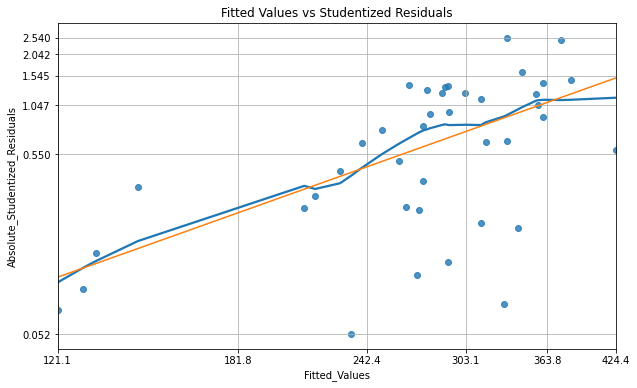

In [29]:
results2 = smf.ols('food_exp~income', foodata).fit()
spread_level(results2, foodata)

Suggested Power Transformation: 2.6126484819030966


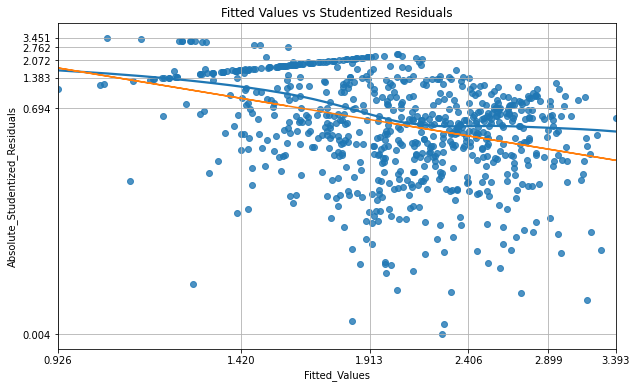

In [30]:
# Fit the model
model = smf.ols('cumgpa ~ sat +hsperc +tothrs +female +black + white', data)
results = model.fit()
spread_level(results, data)

In [36]:
baseball = pd.read_csv('baseball.csv').dropna()
results3 = smf.ols('sal87 ~ years + hits + runs + homeruns', baseball).fit()

Suggested Power Transformation: 0.26461020753844344


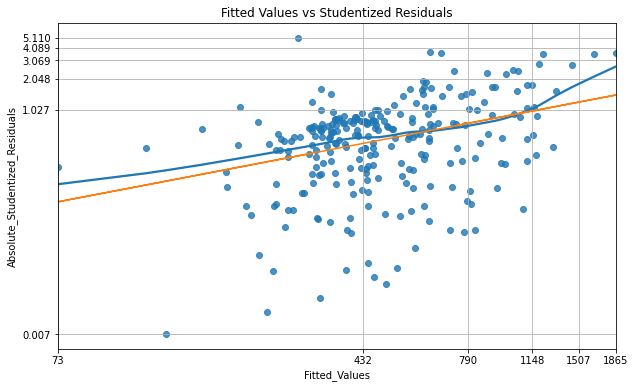

In [37]:
spread_level(results3, baseball)

### Tests for Nonconstant Error Variance

### Bruesch-Pagan Test

In [42]:
# pull out squared residuals
data["res2"] = results.resid**2

# try to predict the squared residuals using a linear combination of our variables
aux_reg = smf.ols('res2 ~ sat +hsperc +tothrs +female +black + white', data).fit()

# Get the regression f-statistic (f-test version)
f = aux_reg.fvalue
fp = aux_reg.f_pvalue

print("The F-Statistic for the Auxiliary Regression is: "+ str(f) +" and the P-Value is: "+ str(fp))

The F-Statistic for the Auxiliary Regression is: 49.18699087724235 and the P-Value is: 9.680220020442915e-51


Therefore we reject the null hypothesis that $\delta_1 =\delta_2=...= \delta_k = 0$ and conclude heteroscedasticity is present in the sample. 

In [64]:
y, X = pt.dmatrices('cumgpa ~ sat +hsperc +tothrs +female +black + white', data,
                   return_type = 'dataframe')

# Takes in the residuals and our design matrix as arguments
# Order is Lm Test statistic, LM P-value, F-stat, F-Pvalue
sm.stats.diagnostic.het_breuschpagan(results.resid, X)

(211.76807825368095,
 5.915341448453325e-43,
 49.18699087724235,
 9.680220020442915e-51)

In [43]:
# LM test statsitic is just n*R2 from the aux regression
LM = len(data)*aux_reg.rsquared

k = results.df_model

In [44]:
# sf is just 1- cdf (called the survival function)
stats.chi2(k).sf(LM)

5.915341448453325e-43

### White Test

The white test procedure is equivalent to the BP test, except that 2nd order terms and interactions are added to teh auxiliary regression. Note that this will eat up degrees of freedom for this implementation of the test. 

In [46]:
# Order is Lm Test statistic, LM P-value, F-stat, F-Pvalue
sm.stats.diagnostic.het_white(results.resid, X)

(373.54693566461617,
 4.825921983841415e-65,
 32.07881392043317,
 8.692792444556739e-94)

### Goldfeld-Quandt Test

In [140]:
# I need to provide a split point to the software
# Sprt values in ascending order and reset the index to number from 1 to len(data)
sortedv = data.sort_values(by = "black").copy().reset_index()

# This returns the first index that contains a one
splt = sortedv.black.argmax()

# run regression
gq_reg = smf.ols('cumgpa ~ sat +hsperc +tothrs +female +black + white', sortedv).fit()

In [141]:
# get the data for dependent and independent variables
# these are numpy arrays instead of dataframes
y = gq_reg.model.endog
X = gq_reg.model.exog

# Order is f-stat, pvalue, hypothesis
sm.stats.diagnostic.het_goldfeldquandt(y, X, idx = 5, alternative = 'increasing', split= splt)

(1.0065563350797613, 0.4901417839642259, 'increasing')

In [142]:
# get the data for dependent and independent
y = gq_reg.model.endog
X = gq_reg.model.exog

# Order is f-stat, pvalue, hypothesis
sm.stats.diagnostic.het_goldfeldquandt(y, X, idx = 5, alternative = 'two-sided', split= splt)

(1.0065563350797613, 0.9396730744525191, 'two-sided')

In [49]:
# manual implementation
data1 = data[data.black == 1]
data0 = data[data.black == 0]

# run regs on different groups
reg1 = smf.ols('cumgpa ~ sat +hsperc +tothrs +female +black + white', data1).fit()
reg0 = smf.ols('cumgpa ~ sat +hsperc +tothrs +female +black + white', data0).fit()

# pull out the residuals of each regression
df1 = reg1.df_resid
df0 = reg0.df_resid

# Get the variance of each regression
sig1squared = reg1.scale
sig0squared = reg0.scale

fstat = sig1squared/sig0squared

# calculate critical calue for right side test
stats.f.ppf(.95, df1, df0)

1.229602398528648

In [50]:
fstat

1.0065563350797615

$F = \frac{\hat{\sigma}_1^2}{\hat{\sigma}_0^2}$, where $H_0: \hat{\sigma}_1^2 \leq \hat{\sigma}_0^2$ and $H_a: \hat{\sigma}_1^2 > \hat{\sigma}_0^2$

In [51]:
y, X = pt.dmatrices('cumgpa ~ sat +hsperc +tothrs +female +black + white', sortedv,
                   return_type = 'dataframe')

In [52]:
X.iloc[:,5]

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
727    1.0
728    1.0
729    1.0
730    1.0
731    1.0
Name: black, Length: 732, dtype: float64

We fail to reject the null hypothesis

### Robust Standard Errors

In [54]:
robust_reg = smf.ols('cumgpa ~ sat +hsperc +tothrs +female +black + white', data).fit(cov_type = 'HC0')
robust_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 cumgpa   R-squared:                       0.241
Model:                            OLS   Adj. R-squared:                  0.234
Method:                 Least Squares   F-statistic:                     30.67
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           6.76e-33
Time:                        13:15:41   Log-Likelihood:                -929.74
No. Observations:                 732   AIC:                             1873.
Df Residuals:                     725   BIC:                             1906.
Df Model:                           6                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8791      0.302      2.915      0.004       0.288       1.470
sat            0.0009      0.000      3.660      0.000       0.000       0.001
hsperc        -0.0056      0.002     -3.391      0.001      -0.009      -0.002
tothrs         0.0121      0.001     10.713      0.000       0.010       0.014
female         0.1667      0.079      2.123      0.034       0.013       0.321
black         -0.0261      0.181     -0.144      0.885      -0.381       0.329
white          0.0143      0.167      0.085      0.932      -0.314       0.342
==============================================================================
Omnibus:                       15.717   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.426
Skew:                           0.088   Prob(JB):                     6.72e-07
Kurtosis:                       3.949   Cond. No.                     1.01e+04
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
[2] The condition number is large, 1.01e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [55]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 cumgpa   R-squared:                       0.241
Model:                            OLS   Adj. R-squared:                  0.234
Method:                 Least Squares   F-statistic:                     38.31
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           1.73e-40
Time:                        13:15:42   Log-Likelihood:                -929.74
No. Observations:                 732   AIC:                             1873.
Df Residuals:                     725   BIC:                             1906.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8791      0.298      2.952      0.003       0.294       1.464
sat            0.0009      0.000      3.743      0.000       0.000       0.001
hsperc        -0.0056      0.002     -3.463      0.001      -0.009      -0.002
tothrs         0.0121      0.001     12.941      0.000       0.010       0.014
female         0.1667      0.077      2.164      0.031       0.015       0.318
black         -0.0261      0.192     -0.136      0.892      -0.403       0.351
white          0.0143      0.184      0.078      0.938      -0.347       0.375
==============================================================================
Omnibus:                       15.717   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.426
Skew:                           0.088   Prob(JB):                     6.72e-07
Kurtosis:                       3.949   Cond. No.                     1.01e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.01e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [60]:
# pull out squared residuals
data["res2"] = robust_reg.resid**2

# try to predict the squared residuals using a linear combination of our variables
aux_reg = smf.ols('res2 ~ sat +hsperc +tothrs +female +black + white', data).fit()

# Get the regression f-statistic (f-test version)
f = aux_reg.fvalue
fp = aux_reg.f_pvalue

print("The F-Statistic for the Auxiliary Regression is: "+ str(f) +" and the P-Value is: "+ str(fp))

The F-Statistic for the Auxiliary Regression is: 49.18699087724235 and the P-Value is: 9.680220020442915e-51


### Weighted Least Squares

Right now we have a regression model where the errors are asumed to be heteroscedastic:

$$cumgpa_i = \beta_0+ \beta_1 sat +\beta_2 hsperc +\beta_3 tothrs +\beta_4 female +\beta_5 lack + \beta_6 white + e_i$$, $$var(e_i) = \sigma^2_i$$

We would like to know the variance for each pbservation/quantile. This isn't possible so instead we can make an assumption about how the variance of our errors depends on one or several of the regressors. Making this assumption gives us the generalized least square (GLS) estimator. This involves a linear relationship between variance and regressor $x_i$. An example of such a relationship would be:
$$var(e_i)=\sigma^2_i = \sigma^2x_i$$

where the varaince for observation i is a function of some consatnt and the current value of x (so variance would tend to increase as x increases). Then if we can correctly guess the structure of the error term, we, for example, divide our model by $\sqrt(x_i)$ to yieldf a BLUE estimator

In [72]:
# maybe I believe the heteroscedastic relationship is due to sat
w = 1/data.sat

# run a weighted regression and provide weights
# note we can use WLS and robust standrad errors
wls_known = smf.wls('cumgpa ~ sat +hsperc +tothrs +female +black + white', weights = w, data = data).fit()
wls_known.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                 cumgpa   R-squared:                       0.213
Model:                            WLS   Adj. R-squared:                  0.206
Method:                 Least Squares   F-statistic:                     32.66
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           6.67e-35
Time:                        13:48:42   Log-Likelihood:                -928.52
No. Observations:                 732   AIC:                             1871.
Df Residuals:                     725   BIC:                             1903.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0094      0.290      3.483      0.001       0.441       1.578
sat            0.0008      0.000      3.316      0.001       0.000       0.001
hsperc        -0.0057      0.002     -3.537      0.000      -0.009      -0.003
tothrs         0.0108      0.001     11.870      0.000       0.009       0.013
female         0.1358      0.077      1.762      0.078      -0.015       0.287
black          0.0075      0.181      0.041      0.967      -0.348       0.363
white          0.0495      0.174      0.284      0.776      -0.293       0.392
==============================================================================
Omnibus:                       31.141   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               73.970
Skew:                           0.184   Prob(JB):                     8.66e-17
Kurtosis:                       4.513   Cond. No.                     9.43e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.43e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Feasible GLS

Often times we have no diea what the appropriate weights for a model might be. FGLS is a proceudre for estimatinng the proper weights to be included in wls. Here we assume that the variance of the error terms is a function of some variables. 

In [143]:
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               food_exp   R-squared:                       0.385
Model:                            OLS   Adj. R-squared:                  0.369
Method:                 Least Squares   F-statistic:                     23.79
Date:                Fri, 04 Nov 2022   Prob (F-statistic):           1.95e-05
Time:                        12:17:44   Log-Likelihood:                -235.51
No. Observations:                  40   AIC:                             475.0
Df Residuals:                      38   BIC:                             478.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     83.4160     43.410      1.922      0.062      -4.463     171.295
income        10.2096      2.093      4.877      0.000       5.972      14.447
==============================================================================
Omnibus:                        0.277   Durbin-Watson:                   1.894
Prob(Omnibus):                  0.870   Jarque-Bera (JB):                0.063
Skew:                          -0.097   Prob(JB):                        0.969
Kurtosis:                       2.989   Cond. No.                         63.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [147]:
foodata["ehatsq"] = results2.resid**2

# estimate weights
w_est = smf.ols('np.log(ehatsq) ~ income', data = foodata).fit()

vari = np.exp(w_est.fittedvalues) #estimated variances
w = 1/vari**2

fgls =smf.wls('food_exp ~ income', foodata, weights = w).fit()

fgls.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:               food_exp   R-squared:                       0.772
Model:                            WLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     128.6
Date:                Fri, 04 Nov 2022   Prob (F-statistic):           9.21e-14
Time:                        12:41:46   Log-Likelihood:                -234.12
No. Observations:                  40   AIC:                             472.2
Df Residuals:                      38   BIC:                             475.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     73.0257      6.206     11.766      0.000      60.462      85.590
income        11.0233      0.972     11.342      0.000       9.056      12.991
==============================================================================
Omnibus:                        1.459   Durbin-Watson:                   1.806
Prob(Omnibus):                  0.482   Jarque-Bera (JB):                0.606
Skew:                          -0.183   Prob(JB):                        0.739
Kurtosis:                       3.479   Cond. No.                         12.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Missing Observations

In [112]:
housing = pd.read_csv('bh.csv')
housing.isna().sum()

crim       0
zn         0
indus      0
chas       0
nox        0
rm         0
age        0
dis        0
rad        0
tax        0
ptratio    0
b          0
lstat      0
medv       0
dtype: int64

### Removal (Variable or Observation)

In [113]:
housing.shape

(506, 14)

In [114]:
# Generate some random indices to craete NAs
NA_indices1 = np.random.choice(range(0,len(housing)), 100, replace = False)
NA_indices2 = np.random.choice(range(0,len(housing)), 100, replace = False)
# Add NAS to a few columns
housing.loc[NA_indices1,"crim"] = np.NaN
# Add NAS to a few columns
housing.loc[NA_indices2,"tax"] = np.NaN

In [115]:
housing.isna().sum()

crim       100
zn           0
indus        0
chas         0
nox          0
rm           0
age          0
dis          0
rad          0
tax        100
ptratio      0
b            0
lstat        0
medv         0
dtype: int64

### Mean, Median, or Mode Imputation

In [126]:
stat_copy = housing.copy()

# just fill in with your favored statistic
stat_copy["crim"] = housing.crim.fillna(housing.crim.median())
housing.crim.median()

0.301315

In [122]:
stat_copy.isna().sum()

crim         0
zn           0
indus        0
chas         0
nox          0
rm           0
age          0
dis          0
rad          0
tax        100
ptratio      0
b            0
lstat        0
medv         0
dtype: int64

In [124]:
stat_copy.head(10)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.006320,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.301315,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.027290,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.301315,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.069050,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2
5,0.029850,0.0,2.18,0,0.458,6.430,58.7,6.0622,3,222.0,18.7,394.12,5.21,28.7
6,0.088290,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,NaN,15.2,395.60,12.43,22.9
7,0.144550,12.5,7.87,0,0.524,6.172,96.1,5.9505,5,311.0,15.2,396.90,19.15,27.1
8,0.211240,12.5,7.87,0,0.524,5.631,100.0,6.0821,5,311.0,15.2,386.63,29.93,16.5
9,0.170040,12.5,7.87,0,0.524,6.004,85.9,6.5921,5,NaN,15.2,386.71,17.10,18.9


### Prediction

#### KNN

https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html

In [134]:
from sklearn.impute import KNNImputer

# knn imputer uses 5 as a default
imputer = KNNImputer(n_neighbors=5)

knn_df = pd.DataFrame(imputer.fit_transform(housing), columns = housing.columns)
knn_df.head(10)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.006320,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.313690,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.027290,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.047794,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.069050,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
5,0.029850,0.0,2.18,0.0,0.458,6.430,58.7,6.0622,3.0,222.0,18.7,394.12,5.21,28.7
6,0.088290,12.5,7.87,0.0,0.524,6.012,66.6,5.5605,5.0,266.0,15.2,395.60,12.43,22.9
7,0.144550,12.5,7.87,0.0,0.524,6.172,96.1,5.9505,5.0,311.0,15.2,396.90,19.15,27.1
8,0.211240,12.5,7.87,0.0,0.524,5.631,100.0,6.0821,5.0,311.0,15.2,386.63,29.93,16.5
9,0.170040,12.5,7.87,0.0,0.524,6.004,85.9,6.5921,5.0,347.6,15.2,386.71,17.10,18.9


In [135]:
knn_df.isna().sum()

crim       0
zn         0
indus      0
chas       0
nox        0
rm         0
age        0
dis        0
rad        0
tax        0
ptratio    0
b          0
lstat      0
medv       0
dtype: int64

#### Recursive Partitioning